In [130]:
from types import CellType
import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
N = 20 # Number of points in a side of the domain.

Compute the fast laplacian for a 3D case for periodic boundary conditions on all boundaries, and check the results.

# Create manufactured solution

In [131]:
# Discretize u = cos(x) * cos(y) * cos(z) in [0, 2pi]^3
# and its laplacian rhs = -3u.
u = np.empty(shape=(N,N,N))
rhs = np.empty(shape=(N,N,N))
h = 2*np.pi/(N-1)
# Create the manufactured solution
for i in range(N):
  for j in range(N):
    for k in range(N):
      u[i][j][k] = np.cos(h*i)*np.cos(h*j)*np.cos(h*k)
      rhs[i][j][k] = -3*np.cos(h*i)*np.cos(h*j)*np.cos(h*k)
# u = u.reshape(N**3)
# rhs = rhs.reshape(N**3)

# Trivial method (NOT WORKING)

In [23]:
# Create the matrix for the 3D Laplacian operator.
# The unknown is stored as a vector with N^3 components, stored like in mif.
# The rhs has the same shape.
# Therefore, the matrix is a square N^3 x N^3 matrix.
# To compute the matrix, an easier representation as a 6D tensor is used.
A = np.zeros(shape=(N,N,N,N,N,N))
for i in range(N):
  for j in range(N):
    for k in range(N):
            if (i != 0 and i!= N-1):
                # Derivative wrt x.
                A[i][j][k][i][j][k] += -2
                A[i][j][k][(i-1)][j][k] += 1
                A[i][j][k][(i+1)][j][k] += 1
            elif (i ==0):
                A[i][j][k][i  ][j][k] += -2
                A[i][j][k][i+1][j][k] +=  2
            else :
                A[i][j][k][i  ][j][k] += -2
                A[i][j][k][i-1][j][k] +=  2

            if (j != 0 and j!= N-1):
                ## Derivative wrt y.
                A[i][j][k][i][j][k] += -2
                A[i][j][k][i][(j-1)][k] += 1
                A[i][j][k][i][(j+1)][k] += 1
            elif (j ==0):
                A[i][j][k][i][j  ][k] += -2
                A[i][j][k][i][j+1][k] +=  2
            else :
                A[i][j][k][i][j  ][k] += -2
                A[i][j][k][i][j-1][k] +=  2
            if (k != 0 and k!= N-1):
                ## Derivative wrt z.
                A[i][j][k][i][j][k] += -2
                A[i][j][k][i][j][(k-1)] += 1
                A[i][j][k][i][j][(k+1)] += 1
            elif (k ==0):
                A[i][j][k][i][j][k  ] += -2
                A[i][j][k][i][j][k+1] +=  2
            else :                  
                A[i][j][k][i][j][k  ] += -2
                A[i][j][k][i][j][k-1] +=  2
# reshape of the tensor in a matrix
A = A.reshape(N**3,N**3)
#print(A)

In [24]:
# TRY SOLVE THE SYSTEM IN THE "Dummy way"
# set as non singular the system (ie impose the pressure in the point (0, 0, 0))
i = 0
A[i, :] = np.zeros(N**3)
A[i][0] = 1
rhs[i] = u[i]
# Solvw the lin syst A_ij/h**2 x_j = b_i
uh = h**2 * np.linalg.solve(A, rhs)
const = u[0] - uh[0]


N elem:  5 

CHECK:  Max Err:  -0.999999999999977 Min Err:  -1.4674011002723395 check in 0 :  -1.4674011002723395


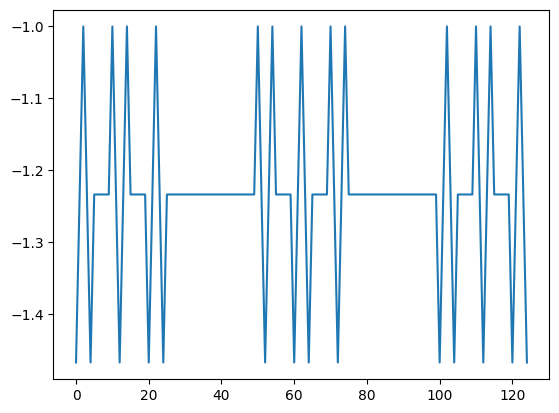

In [28]:
# Check if the laplacian of u is rhs.
print("N elem: ", N, "\n")
print("CHECK: ", "Max Err: ", max(u-uh), "Min Err: ", min(u-uh), "check in 0 : ", const)
# print("Massima discrepanza :", np.max((A @ uh - A @ u)), "Posizione : ", np.argmax((A @ uh - A @ u)) )
# print("Minima discrepanza  :", np.min((A @ uh - A @ u)), "Posizione : ", np.argmin((A @ uh - A @ u)) )
# Correct convergence order (2).
#plt.plot(u, '-ro')
#plt.plot(uh + const, '-bo')
plt.plot(u-uh)
plt.show()

# DCT solver

In [132]:
# COMPUTE bHat
bHat = np.copy(rhs)
# bHat = bHat.reshape(N, N, N)
# for i in range(N):
#     for j in range(N):
#         for k in range(N):
#             if( i == 0 or i == N-1):
#                 bHat[i][j][k] /= np.sqrt(2)
#             if( j == 0 or j == N-1):
#                 bHat[i][j][k] /= np.sqrt(2)
#             if( k == 0 or k == N-1):
#                 bHat[i][j][k] /= np.sqrt(2)
# for l in range(N):
#     for m in range(N):
#         bHat[0 ][l][m] /= np.sqrt(2)
#         bHat[-1][l][m] /= np.sqrt(2)
# for l in range(1, N-1):
#     for m in range(N):
#         bHat[l][0 ][m] /= np.sqrt(2)
#         bHat[l][-1][m] /= np.sqrt(2)
# for l in range(1, N-1):
#     for m in range(1, N-1):
#         bHat[l][m][0 ] /= np.sqrt(2)
#         bHat[l][m][-1] /= np.sqrt(2)

In [133]:
# COMPUTE BTIlDA
btilda = np.empty(shape=(N,N,N))
# dct along x
btilda = bHat
for j in range(N):
    for k in range(N):
        btilda[:][j][k] = scipy.fftpack.dct(bHat[:][j][k], type=1, norm='ortho')
# dct along y
bHat = btilda
for i in range(N):
    for k in range(N):
        btilda[i][:][k] = scipy.fftpack.dct(bHat[i][:][k], type=1, norm='ortho')
# dct along z
bHat = btilda
for i in range(N):
    for j in range(N):
        btilda[i][j][:] = scipy.fftpack.dct(bHat[i][j][:], type=1, norm='ortho')

In [146]:
# Compute x_tilda (Sol in dct space)
xtilde = np.copy(btilda)
xtilde[0,0,0] = 0
for i in range(1,N):
  for j in range(N):
    for k in range(N):
      eigx = (2*np.cos(np.pi * (i) / (N-1))-2)
      eigy = (2*np.cos(np.pi * (j) / (N-1))-2)
      eigz = (2*np.cos(np.pi * (k) / (N-1))-2)
      xtilde[i][j][k] /= (eigx + eigy + eigz)*h**2
i = 0
for j in range (1, N):
    for k in range(N):
        
      eigx = (2*np.cos(np.pi * (i) / (N-1))-2)
      eigy = (2*np.cos(np.pi * (j) / (N-1))-2)
      eigz = (2*np.cos(np.pi * (k) / (N-1))-2)
      xtilde[i][j][k] /= (eigx + eigy + eigz)*h**2
i = 0
j = 0
for k in range(1, N):
    
      eigx = (2*np.cos(np.pi * (i) / (N-1))-2)
      eigy = (2*np.cos(np.pi * (j) / (N-1))-2)
      eigz = (2*np.cos(np.pi * (k) / (N-1))-2)
      xtilde[i][j][k] /= (eigx + eigy + eigz)*h**2
xtilde2 = xtilde


In [147]:
# Compute xhat
# idct along x
for j in range(N):
    for k in range(N):
        xtilde2[:][j][k] = scipy.fftpack.dct(xtilde[:][j][k], type=1, norm='ortho')
# idct along y
xtilde3 = xtilde2
for i in range(N):
    for k in range(N):
        xtilde3[i][:][k] = scipy.fftpack.dct(xtilde2[i][:][k], type=1, norm='ortho')
# idct along z
xHat = xtilde3
for i in range(N):
    for j in range(N):
        xHat[i][j][:]    = scipy.fftpack.dct(xtilde3[i][j][:], type=1, norm='ortho')
# Get solution (ie from xhat to x)
xview = np.copy(xHat)
# for l in range(N):
#     for m in range(N):
#         xview[0 ][l][m] *= np.sqrt(2)
#         xview[-1][l][m] *= np.sqrt(2)
# for l in range(1, N-1):
#     for m in range(N):
#         xview[l][0 ][m] *= np.sqrt(2)
#         xview[l][-1][m] *= np.sqrt(2)
# for l in range(1, N-1):
#     for m in range(1, N-1):
#         xview[l][m][0 ] *= np.sqrt(2)
#         xview[l][m][-1] *= np.sqrt(2)
                
# we now have the final solution in xview
# Perform checks of the solution with the manufactured solution u = c(x)*c(y)*c(z) in [0, 2pi]^3
# x = xview.reshape(N**3)
# u = u.reshape(N**3)


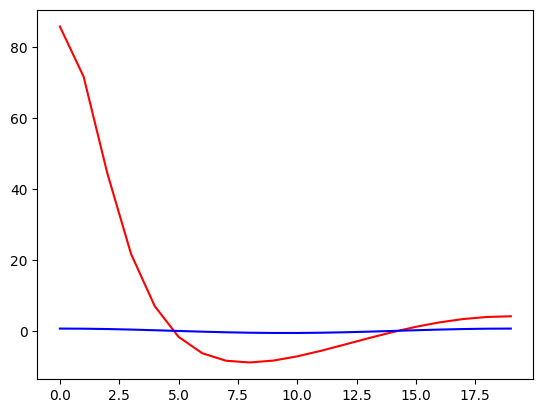

In [148]:
   
x = [xview[i ][2][2] for i in range(N)]
uh = [ np.cos(h*i)*np.cos(h*2)*np.cos(h*2) for i in range(N)]
plt.plot(x, '-r')
plt.plot(uh, '-b')
plt.show()
